# Dogs vs Cats
## Kaggle Dataset의 일부를 이용한 개, 고양이 구분
### Dog Image: 12,500개, Cat Image: 12,500개, 총 25,000개
### One-Hot Encoding
### Data shuffling
### 출처: [pontoregende GitHub](https://github.com/pontorezende/Dogs-vs-Cats-Redux-with-CNN)

In [1]:
import numpy as np
from glob import glob
import cv2, os, random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import plaidml.keras
plaidml.keras.install_backend()

ModuleNotFoundError: No module named 'plaidml'

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
# seed 값 설정
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
path='dogs-vs-cats/train/train/'

### data set 정리

In [7]:
## used for resize and in our model
ROW, COL = 96, 96

dogs, cats = [], []
y_dogs, y_cats = [], []

In [8]:
dog_path = os.path.join(path, 'dog.*')
len(glob(dog_path))

12500

In [9]:
## Load some our dog images (12,500 개 이미지)
dog_path = os.path.join(path, 'dog.*')
for dog_img in glob(dog_path):
    dog = cv2.imread(dog_img)
    dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
    dog = cv2.resize(dog, (ROW, COL))
    dog = image.img_to_array(dog)
    dogs.append(dog)

In [10]:
## Load some our cat images (12,500 개 이미지)
cat_path = os.path.join(path, 'cat.*')
for cat_img in glob(cat_path):
    cat = cv2.imread(cat_img)
    cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
    cat = cv2.resize(cat, (ROW, COL))
    cat = image.img_to_array(cat)
    cats.append(cat)

In [11]:
classes = ['dog', 'cat']

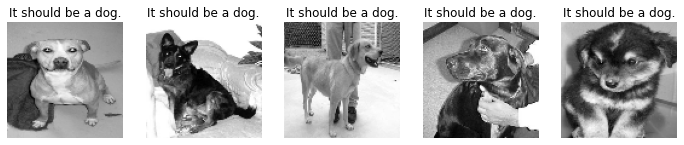

In [12]:
# 제대로 load가 되었는지 확인
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = image.array_to_img(random.choice(dogs))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    
    plt.axis('off')
    plt.title('It should be a {}.'.format(classes[0]))
plt.show()

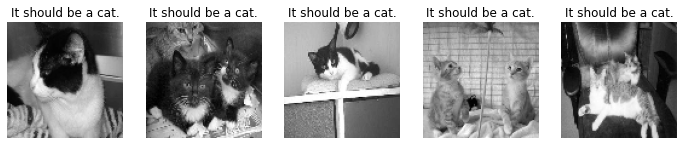

In [13]:
plt.figure(figsize=(12,8))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = image.array_to_img(random.choice(cats))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

    plt.axis('off')
    plt.title('It should be a {}.'.format(classes[1]))
plt.show()

In [14]:
## just change the labels for 0 and  1
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]

In [15]:
y_dogs[0], y_cats[0]

(1, 0)

In [16]:
## converting everything to Numpy array to fit in our model
## them creating a X and target file like we used to see
## in Machine and Deep Learning models
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [17]:
X_concat = np.concatenate((dogs,cats), axis=0)
y_concat = np.concatenate((y_dogs, y_cats), axis=0)

In [18]:
len(X_concat)

25000

In [19]:
X_concat.shape

(25000, 96, 96, 1)

### Train Set과 Test Set으로 분리

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_concat, y_concat, test_size=.2, random_state=seed)
# stratify=y_test

In [21]:
X_train.shape, X_test.shape

((20000, 96, 96, 1), (5000, 96, 96, 1))

### One-Hot Encoding

In [22]:
# import keras
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

### CNN 모델 구성

In [23]:
## CNN모델 구성
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL,1),
          activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [24]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(), metrics=['accuracy'])

In [25]:
## to save checkpoint to use later
modelpath = "model/dogs_vs_cats-cnn-onehot-best.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

### 모델 학습

In [26]:
history = model.fit(X_train, y_train, batch_size=100, epochs=40, validation_split=0.2,
                    callbacks=[checkpointer, early_stopping_callback],
                    shuffle=True)

Epoch 1/40
160/160 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.5088
Epoch 00001: val_loss improved from inf to 0.69133, saving model to model/dogs_vs_cats-cnn-onehot-best.hdf5
160/160 [==============================] - 23s 143ms/step - loss: 0.7119 - accuracy: 0.5088 - val_loss: 0.6913 - val_accuracy: 0.5408
Epoch 2/40
160/160 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.5681
Epoch 00002: val_loss improved from 0.69133 to 0.67437, saving model to model/dogs_vs_cats-cnn-onehot-best.hdf5
160/160 [==============================] - 23s 141ms/step - loss: 0.6803 - accuracy: 0.5681 - val_loss: 0.6744 - val_accuracy: 0.5780
Epoch 3/40
160/160 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.5909
Epoch 00003: val_loss improved from 0.67437 to 0.65196, saving model to model/dogs_vs_cats-cnn-onehot-best.hdf5
160/160 [==============================] - 23s 142ms/step - loss: 0.6663 - accuracy: 0.5909 - val_loss: 0.6520 -

In [38]:
from tensorflow.keras.models import load_model
del model
model = load_model('model/dogs_vs_cats-cnn-onehot-best.hdf5')

In [39]:
scores = model.evaluate(X_test, y_test, verbose=2)
print('MODEL ACCURACY: %.5f' % scores[1])

5000/5000 - 34s - loss: 0.4183 - accuracy: 0.8140
MODEL ACCURACY: 0.81400


In [40]:
# 테스트셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

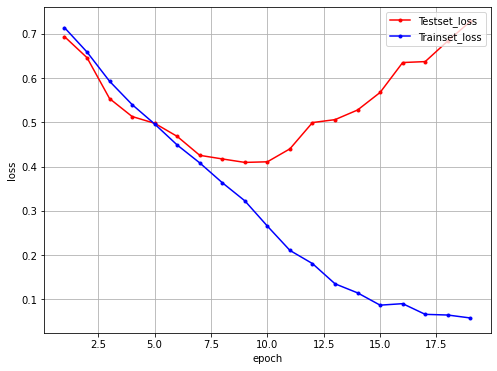

In [41]:
# 그래프로 표현
x_len = np.arange(1, len(y_loss)+1)
plt.figure(figsize=(8,6))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
# plt.axis([0, 20, 0, 0.35])
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()